In [1]:
import pandas as pd
from mysystem.read import StkDataProcessor
from mysystem.backtest import Backtester
from mysystem.output import PerformanceCalculator
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

设置回测开始和结束时间，获取此时间段内所有交易日

In [2]:
backtester = Backtester(start_date='2021-01-01', end_date='2022-01-01',initial_capital=10000000)
trading_days_list = backtester.get_trading_days()
print(trading_days_list)

          date  net_value
0   2021-01-04   10000000
1   2021-01-05   10000000
2   2021-01-06   10000000
3   2021-01-07   10000000
4   2021-01-08   10000000
..         ...        ...
238 2021-12-27   10000000
239 2021-12-28   10000000
240 2021-12-29   10000000
241 2021-12-30   10000000
242 2021-12-31   10000000

[243 rows x 2 columns]


生成交易信号

In [4]:
backtester.reset_signals() 

# 设置交易频率
trading_frequency = 1

# 遍历交易日列表，进行交易
for i in range(0, len(trading_days_list), trading_frequency):
    # 获取交易日期
    current_date = trading_days_list[i]

    # 调用clear函数清仓
    backtester.clear(date=current_date)

    # 获取过去5天的股票行情数据
    start_date = current_date - pd.DateOffset(days=5)
    end_date = current_date
    stock_data =  backtester.data_processor.get_stock_data(start_date=start_date, end_date=end_date)
    
    # 生成一个预选股池，比如去掉停牌天数太多的
    _, suspended_days_count, _ = backtester.data_processor.count_trading_days(start_date=start_date, end_date=end_date)
    suspended_stocks = [stock_id for stock_id, days_count in suspended_days_count.items() if days_count > 3]
    selected_stocks = [stock_id for stock_id in backtester.data_processor.stock_ids if stock_id not in suspended_stocks]

    # 计算股票累计收益率
    cumulative_returns = backtester.data_processor.calculate_cumulative_returns(stock_codes=selected_stocks, start_date=start_date, end_date=end_date)

    # 获取排名前0.5%的股票作为反转策略的组合
    top_stk = cumulative_returns.nlargest(int(0.0005 * len(cumulative_returns)), 'cumulative_returns')

    # 获取股票列表和交易量（假设默认为100股）
    stock_list = top_stk['stk_id'].tolist()
    volume = 100

    # 调用buy函数进行买入操作
    backtester.buy(date=current_date, stock_list=stock_list, volume=volume)

backtester.signals.to_csv('signals.csv', index=False)

上述生成过程可能比较慢。也可以直接读取'signals.csv'继续以下步骤

In [5]:
backtester.reset_signals('signals.csv') # 直接从文件读取交易信号
print(backtester.signals)

           date     stk_id action  volume
0    2021-01-04        NaN  clear     NaN
1    2021-01-04  688063.SH    buy   100.0
2    2021-01-04  688686.SH    buy   100.0
3    2021-01-05        NaN  clear     NaN
4    2021-01-05  688686.SH    buy   100.0
..          ...        ...    ...     ...
724  2021-12-30  301189.SZ    buy   100.0
725  2021-12-30  301166.SZ    buy   100.0
726  2021-12-31        NaN  clear     NaN
727  2021-12-31  301189.SZ    buy   100.0
728  2021-12-31  301166.SZ    buy   100.0

[729 rows x 4 columns]


开始回测

In [ ]:
backtester.initialize_account()
net_values = backtester.run_backtest() # 运行结束会自动生成net_values.csv并保存

上述生成过程可能比较慢。也可以直接读取'net_values.csv'继续以下步骤

开始计算performance

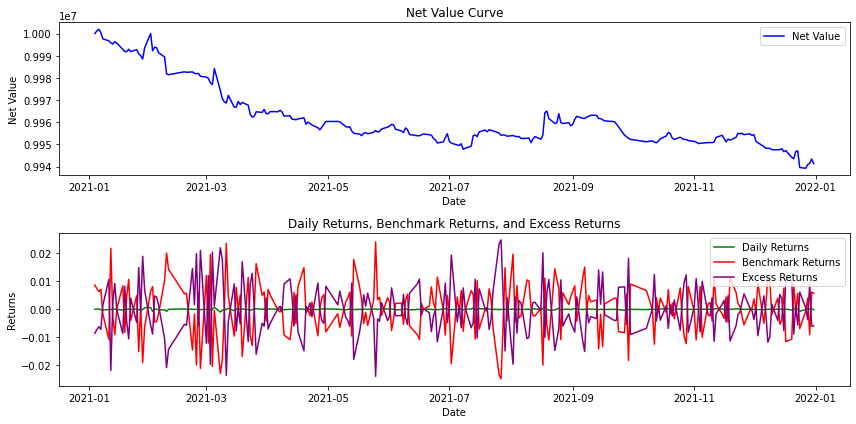

{'annualized_returns': -0.006081932502657761, 'annualized_volatility': 0.0031184195196764285, 'sharpe_ratio': -0.08244902404277792, 'max_drawdown': -0.006266464998985377}


In [2]:
net_values = pd.read_csv('net_values.csv') # 直接从文件读取净值信息
performance_calculator = PerformanceCalculator()
performance_result = performance_calculator.calculate_performance(net_values)

# 打印结果
print(performance_result)